In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner
from jnkepler.jaxttv import jaxttv, elements_to_pdic, params_to_elements
from jax.config import config
import numpyro, jax
config.update('jax_enable_x64', True)
#numpyro.set_host_device_count(1)
print ('# jax device count:', jax.local_device_count())

# jax device count: 1


In [2]:
npl = 6
datadir = "./toi1136/toi1136_fei/"
datadir = "./toi1136/toi1136_fei_2/"
import glob

In [3]:
tcobs, errorobs, p_init = [], [], []
for i in range(npl):
    fname = glob.glob(datadir + "*_planet%d_ephemeris.txt"%(i))[0]
    tnum, tc, tcerr = np.array(pd.read_csv(fname, delim_whitespace=True)).T
    tcobs.append(tc)
    errorobs.append(tcerr)
    p, t0 = np.polyfit(tnum, tc, deg=1)
    p_init.append(p)
p_init = np.array(p_init)

In [4]:
import itertools
tclist = list(itertools.chain.from_iterable(tcobs))
print (p_init[0])
print (np.min(tclist), np.max(tclist))

4.171817635859455
1684.2802907079106 2650.0309951


In [6]:
dt = 0.1
t_start, t_end = 1680, 2655
jttv = jaxttv(t_start, t_end, dt)

# sympletic integrator is used.


In [7]:
jttv.set_tcobs(tcobs, p_init, errorobs=errorobs)

# integration starts at:           1680.00
# first transit time in data:      1684.28
# last transit time in data:       2650.03
# integration ends at:             2655.00
# integration time step:           0.1000 (1/41 of innermost period)


In [8]:
outdir = "toi1136/test_"
outdir = "toi1136/test_4chains_"
outdir = "toi1136/test2_"

initial objective function: 8985.58 (82 data)

running LM optimization...
objective function: 49.55 (82 data)
# elapsed time (least square): 101.8 sec


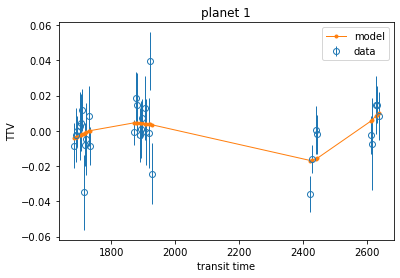

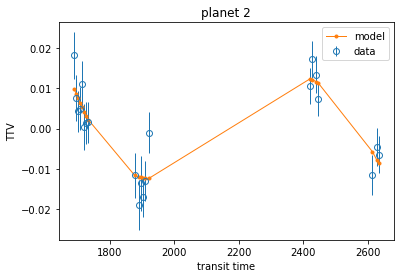

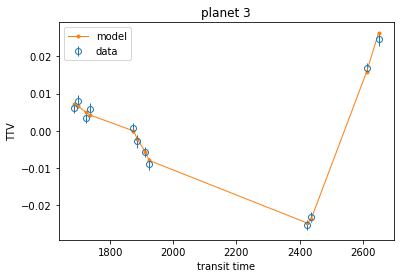

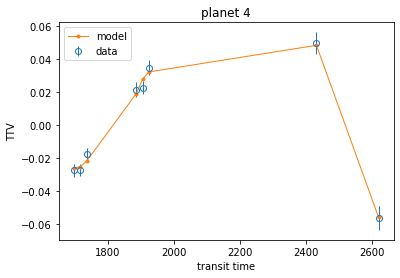

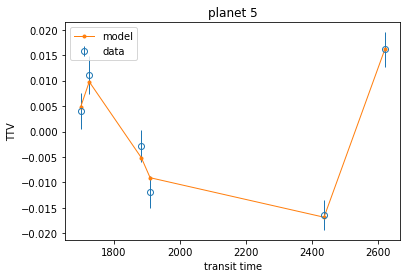

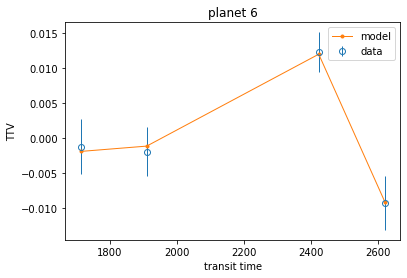

In [9]:
params_best = jttv.optim(amoeba=False, mmax=1e-4, emax=0.15, save=outdir+"ql")

In [10]:
pdic = pd.DataFrame(elements_to_pdic(*params_to_elements(params_best, jttv.nplanet)))
print (pdic)

      pmass     period     ecosw     esinw  cosi  lnode          tic  \
0  1.618122   4.172227  0.121570 -0.000201  -0.0    0.0  1684.284495   
1  1.731403   6.257439  0.001929 -0.119543   0.0    0.0  1688.715216   
2  3.517530  12.518486 -0.054334  0.075826   0.0   -0.0  1686.067589   
3  2.961898  18.799835  0.000424 -0.067872  -0.0    0.0  1697.763634   
4  6.423260  26.319294  0.014134 -0.044063  -0.0    0.0  1699.391149   
5  8.918108  39.537911  0.013682 -0.134084   0.0    0.0  1711.934027   

        ecc     omega     lnmass      mass      cosw      sinw  
0  0.121570 -0.001657 -12.234469  0.000005  0.999999 -0.001657  
1  0.119558 -1.554657 -12.166804  0.000005  0.016139 -0.999870  
2  0.093283  2.192554 -11.457977  0.000011 -0.582465  0.812856  
3  0.067874 -1.564546 -11.629906  0.000009  0.006250 -0.999980  
4  0.046275 -1.260404 -10.855810  0.000019  0.305432 -0.952214  
5  0.134781 -1.469111 -10.527652  0.000027  0.101510 -0.994834  


In [11]:
tc, de = jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))
print ("energy error:", de)

energy error: 9.874199236037384e-10


In [12]:
%timeit jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))

45.7 ms ± 2.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
pdic_init = elements_to_pdic(*params_to_elements(params_best, jttv.nplanet), outkeys=['period', 'ecc', 'cosw', 'sinw', 'cosi', 'lnode', 'tic', 'lnmass', 'mass'])
tic_guess = jnp.array([_tcobs[0] for _tcobs in jttv.tcobs])
p_guess = jnp.array(p_init)
ones = jnp.ones_like(p_guess)

In [14]:
from numpyro.infer import init_to_value
import numpyro.distributions as dist
import jax.random as random

def model(dp=5e-1, dtic=1e-1, emax=0.5, mmin=1e-7, mmax=1e-3, uniform_mass=False, tcjitter=False):
    tic = numpyro.sample("tic", dist.Uniform(low=tic_guess-dtic, high=tic_guess+dtic))
    period = numpyro.sample("period", dist.Uniform(low=p_guess-dp, high=p_guess+dp))
    ecc = numpyro.sample("ecc", dist.Uniform(low=ones*0, high=ones*emax))

    cosw = numpyro.sample("cosw", dist.Normal(scale=ones))
    sinw = numpyro.sample("sinw", dist.Normal(scale=ones))
    omega = jnp.arctan2(sinw, cosw)
    numpyro.deterministic("omega", omega)

    lnode = ones * 0
    numpyro.deterministic("lnode", lnode)
    cosi = ones * 0
    numpyro.deterministic("cosi", cosi)
    if uniform_mass:
        mass = numpyro.sample("mass", dist.Uniform(low=ones*mmin, high=ones*mmax))
        numpyro.deterministic("lnmass", jnp.log(mass))
    else:
        lnmass = numpyro.sample("lnmass", dist.Uniform(low=ones*jnp.log(mmin), high=ones*jnp.log(mmax)))
        mass = jnp.exp(lnmass)
        numpyro.deterministic("mass", mass)

    elements = jnp.array([period, ecc*cosw, ecc*sinw, cosi, lnode, tic]).T
    numpyro.deterministic("elements", elements)

    #tcmodel, ediff = jttv.get_ttvs_hermite4(elements, jnp.hstack([1, mass]))
    tcmodel, ediff = jttv.get_ttvs(elements, jnp.hstack([1., mass]))
    if tcjitter:
        lntcjitter = numpyro.sample("lntcjitter", dist.Uniform(low=-8, high=-2))
        tcjitter = numpyro.deterministic("tcjitter", jnp.exp(lntcjitter))
        tcerrmodel = jnp.sqrt(jttv.errorobs_flatten**2 + tcjitter**2)
    else:
        tcerrmodel = jttv.errorobs_flatten
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=tcerrmodel), obs=jttv.tcobs_flatten)

In [15]:
#pdic_init['lntcjitter'] = -4.8
init_strategy = init_to_value(values=pdic_init)
pdic_init

{'period': DeviceArray([ 4.17222712,  6.25743922, 12.5184861 , 18.79983487,
              26.31929446, 39.53791084], dtype=float64),
 'cosi': DeviceArray([-0.,  0.,  0., -0., -0.,  0.], dtype=float64),
 'lnode': DeviceArray([ 0.,  0., -0.,  0.,  0.,  0.], dtype=float64),
 'tic': DeviceArray([1684.28449539, 1688.71521582, 1686.06758916, 1697.76363385,
              1699.39114883, 1711.9340269 ], dtype=float64),
 'ecc': DeviceArray([0.12156989, 0.11955826, 0.09328308, 0.06787371, 0.04627472,
              0.1347805 ], dtype=float64),
 'lnmass': DeviceArray([-12.23446936, -12.16680375, -11.45797687, -11.6299056 ,
              -10.85581012, -10.527652  ], dtype=float64),
 'mass': DeviceArray([4.86001341e-06, 5.20025057e-06, 1.05648631e-05,
              8.89602863e-06, 1.92921917e-05, 2.67854428e-05],            dtype=float64),
 'cosw': DeviceArray([ 0.99999863,  0.01613854, -0.58246474,  0.00624991,
               0.30543249,  0.10151032], dtype=float64),
 'sinw': DeviceArray([-0.001657 

In [16]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.8, init_strategy=init_strategy)

In [17]:
#nw, ns = 100, 100 # 9h 30min, test
#nw, ns = 500, 500 # ~70hr, test
nw, ns = 100, 100 # test2, dt=0.1, 16hr

In [18]:
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)

In [ ]:
#mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns, num_chains=4, progress_bar=False)

In [19]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, mmin=0, mmax=1e-4, uniform_mass=True)

  0%|                                                                                                               | 0/200 [00:00<?, ?it/s]2022-04-16 15:33:50.083979: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit__body_fn.225
********************************
sample: 100%|████████████████████████████████████████████| 200/200 [15:51:43<00:00, 285.52s/it, 1023 steps of size 4.50e-03. acc. prob=0.93]


In [20]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   cosw[0]      0.73      0.15      0.69      0.49      0.93      5.34      1.51
   cosw[1]      0.08      0.13      0.08     -0.12      0.27      7.71      1.11
   cosw[2]     -0.28      0.18     -0.26     -0.61     -0.06      5.58      1.12
   cosw[3]      0.14      0.15      0.15     -0.11      0.35      5.45      1.03
   cosw[4]      0.18      0.27      0.10     -0.23      0.68      5.99      1.25
   cosw[5]      0.08      0.05      0.09      0.00      0.17     12.97      1.07
    ecc[0]      0.13      0.02      0.13      0.10      0.16     13.87      1.00
    ecc[1]      0.08      0.02      0.08      0.06      0.11     11.06      1.08
    ecc[2]      0.11      0.03      0.11      0.06      0.16      5.45      0.99
    ecc[3]      0.14      0.07      0.12      0.03      0.25      3.84      1.65
    ecc[4]      0.06      0.02      0.05      0.02      0.09      6.69      1.15
    ecc[5]      0.12      0

In [21]:
import dill
with open(outdir+"mcmc.pkl", "wb") as f:
    dill.dump(mcmc, f)

In [22]:
samples = mcmc.get_samples()

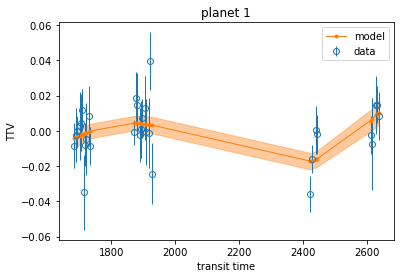

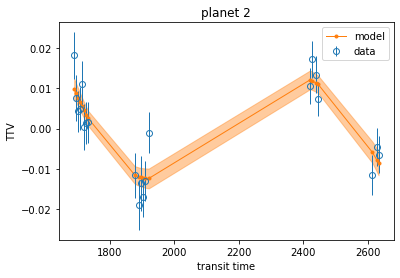

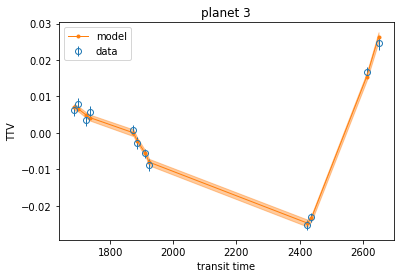

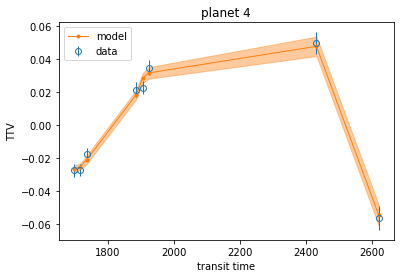

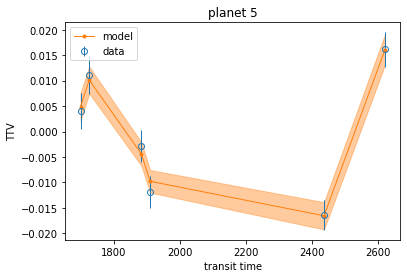

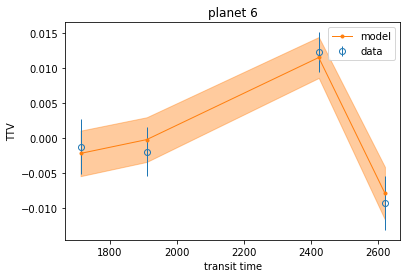

In [23]:
idx = samples['ediff']==samples['ediff']
mmodel, smodel = jnp.mean(samples['tcmodel'][idx], axis=0), jnp.std(samples['tcmodel'][idx], axis=0)
jttv.quicklook(mmodel, sigma=smodel, save=outdir+"postm")

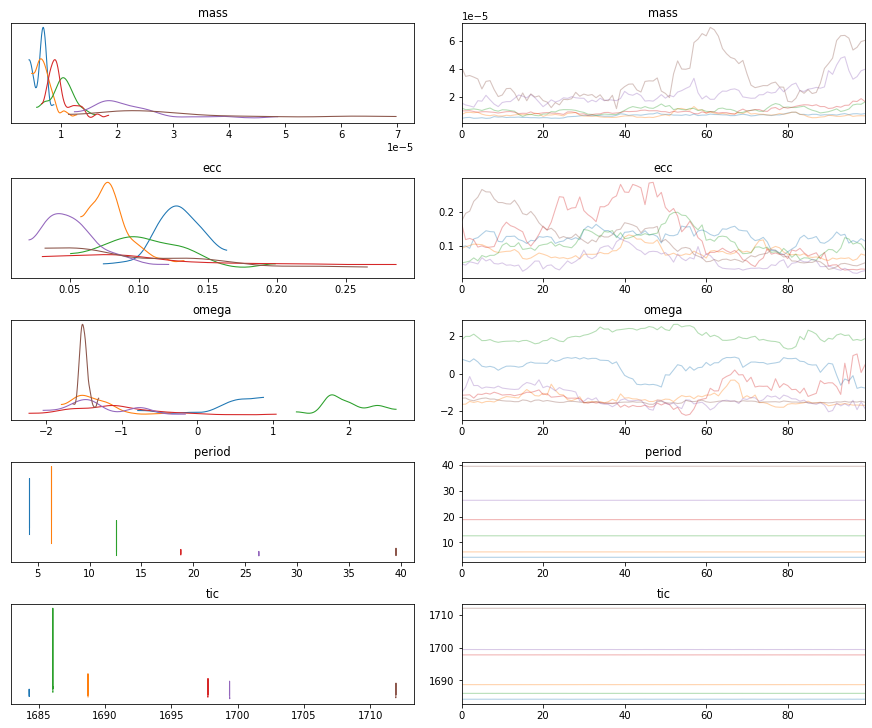

In [24]:
import arviz
fig = arviz.plot_trace(mcmc, var_names=['mass', 'ecc', 'omega', 'period', 'tic'])

# planet 1 res std: 1.31e-02	 res/raw err std: 0.86	 res/estimated err std: 0.86
# planet 2 res std: 4.57e-03	 res/raw err std: 0.87	 res/estimated err std: 0.87
# planet 3 res std: 1.05e-03	 res/raw err std: 0.68	 res/estimated err std: 0.68
# planet 4 res std: 3.06e-03	 res/raw err std: 0.75	 res/estimated err std: 0.75
# planet 5 res std: 1.20e-03	 res/raw err std: 0.38	 res/estimated err std: 0.38
# planet 6 res std: 1.20e-03	 res/raw err std: 0.34	 res/estimated err std: 0.34


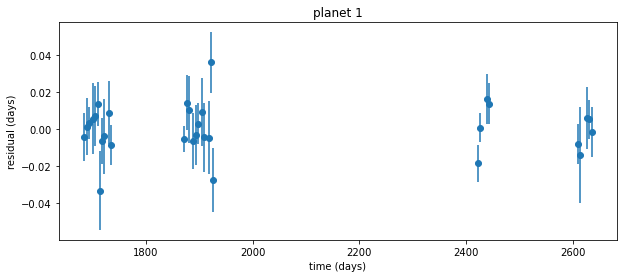

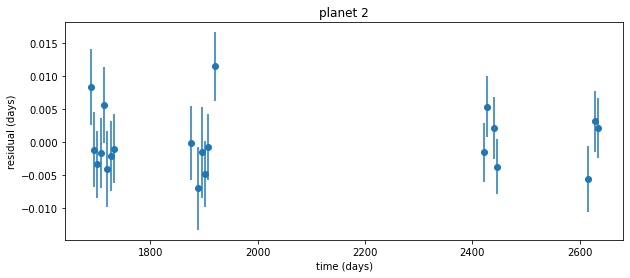

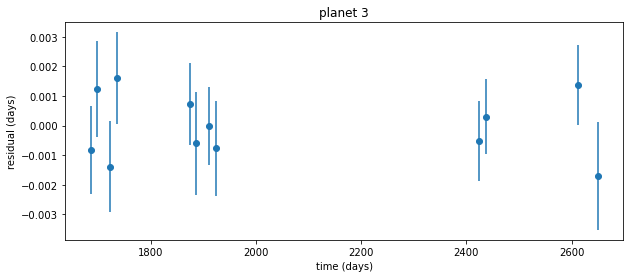

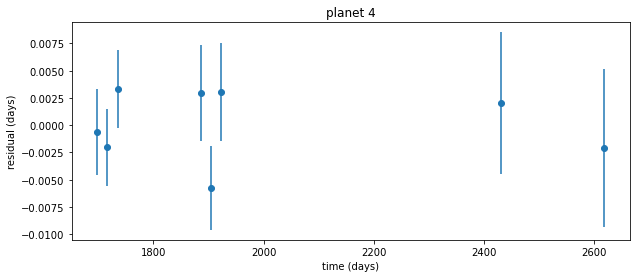

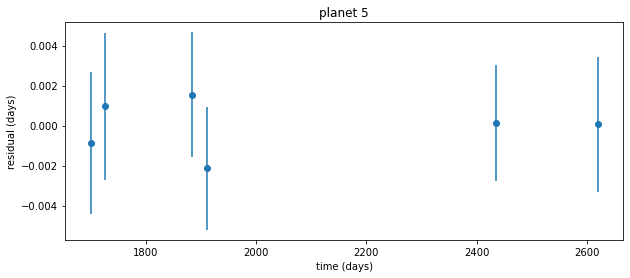

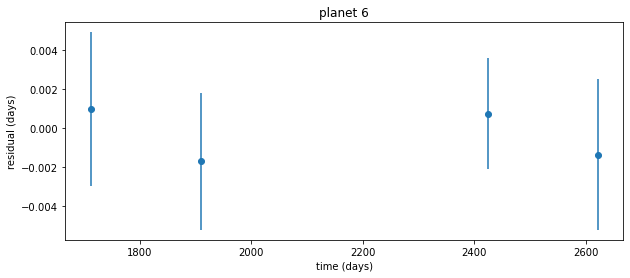

In [25]:
meanjit = 0
for j in range(npl):
    plt.figure(figsize=(10,4))
    _idx = jttv.pidx==j+1
    res = jttv.tcobs_flatten[_idx]-mmodel[_idx]
    err0 = jttv.errorobs_flatten[_idx]
    err = np.sqrt(err0**2 + meanjit**2)
    print ("# planet", j+1, "res std: %.2e\t"%np.std(res), "res/raw err std: %.2f\t"%np.std(res/err0), 
           "res/estimated err std: %.2f"%np.std(res/err))
    #plt.errorbar(jttv.tcobs_flatten[_idx], res/jttv.errorobs_flatten[_idx], fmt='o')
    plt.errorbar(jttv.tcobs_flatten[_idx], res, yerr=jttv.errorobs_flatten[_idx], fmt='o')
    plt.title("planet %d"%(j+1))
    plt.xlabel("time (days)")
    plt.ylabel('residual (days)')

In [26]:
M_earth = 3.0034893e-6
samples['pmass'] = samples['mass'] / M_earth
keys = ['pmass', 'tic', 'period', 'ecc', 'omega']

(array([ 2.,  0.,  1.,  4.,  4.,  4., 13., 22., 23., 27.]),
 array([-11.12820394, -10.87529812, -10.6223923 , -10.36948648,
        -10.11658065,  -9.86367483,  -9.61076901,  -9.35786319,
         -9.10495737,  -8.85205154,  -8.59914572]),
 <BarContainer object of 10 artists>)

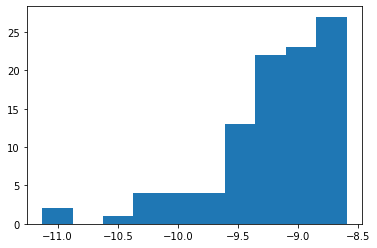

In [27]:
plt.hist(np.log10(np.abs(samples['ediff'])))

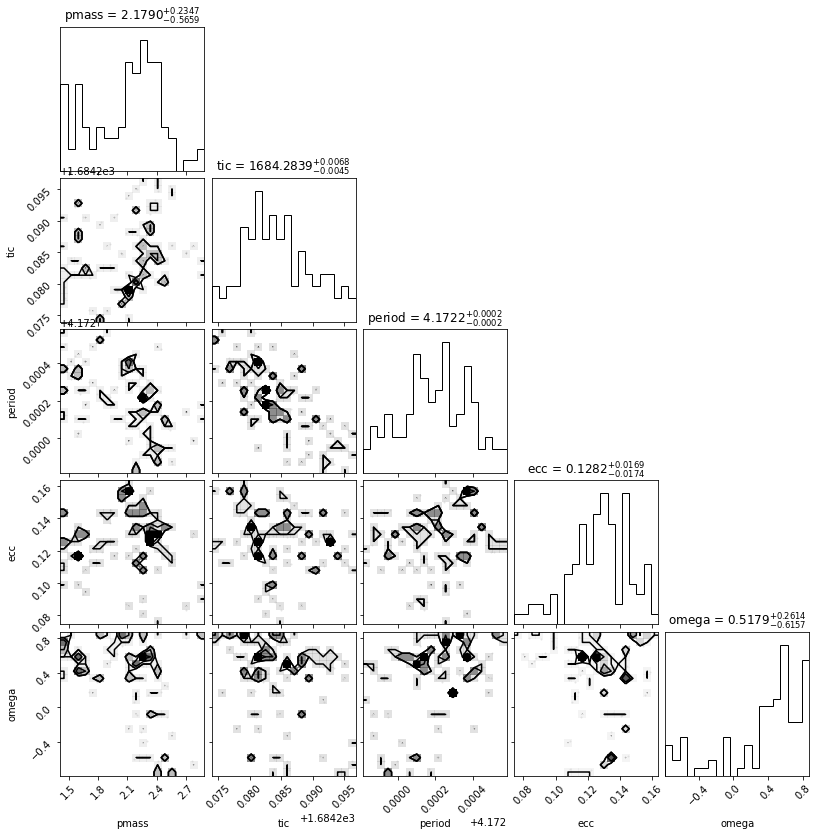

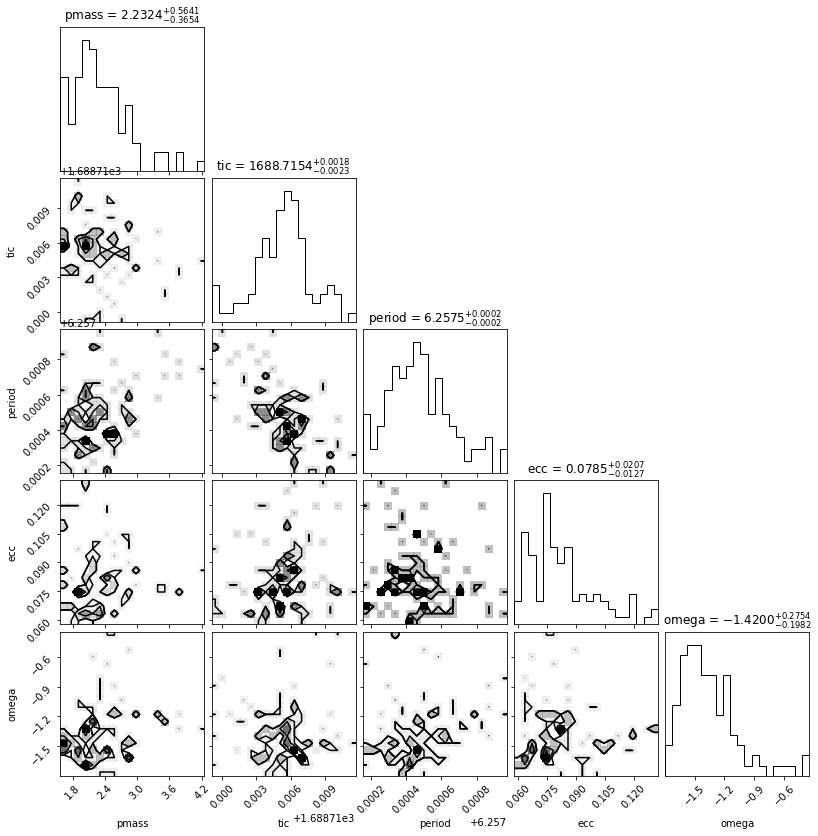

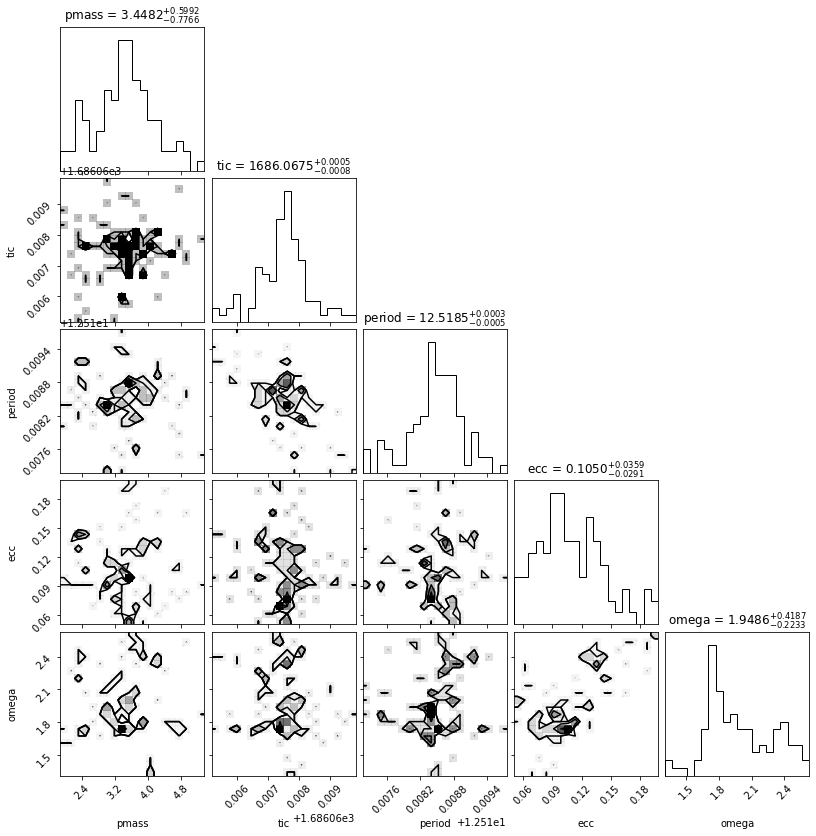

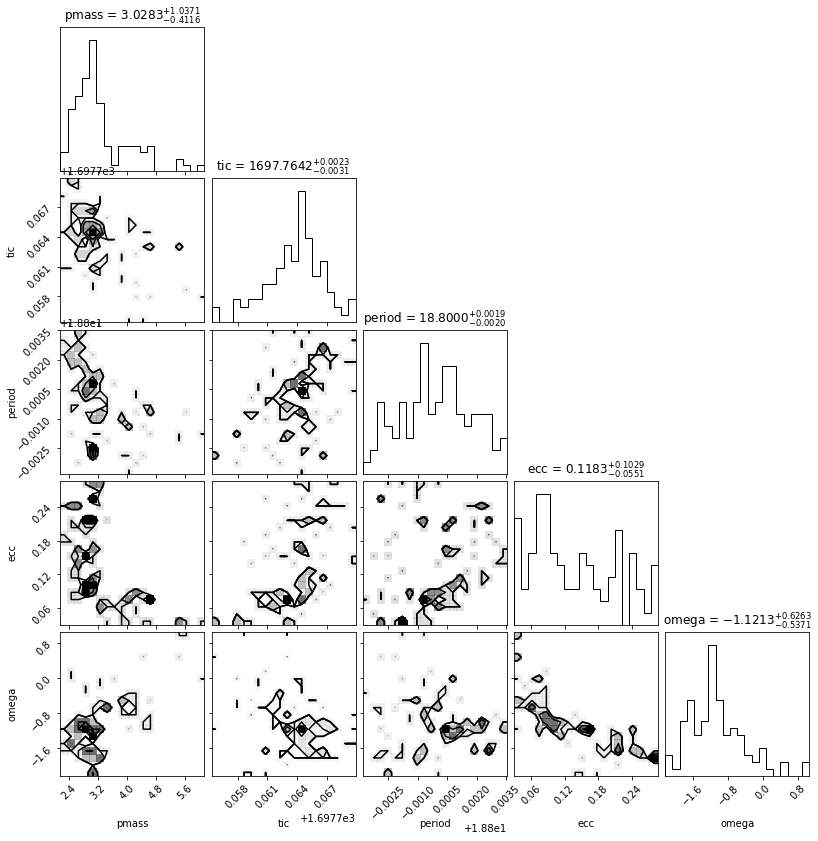

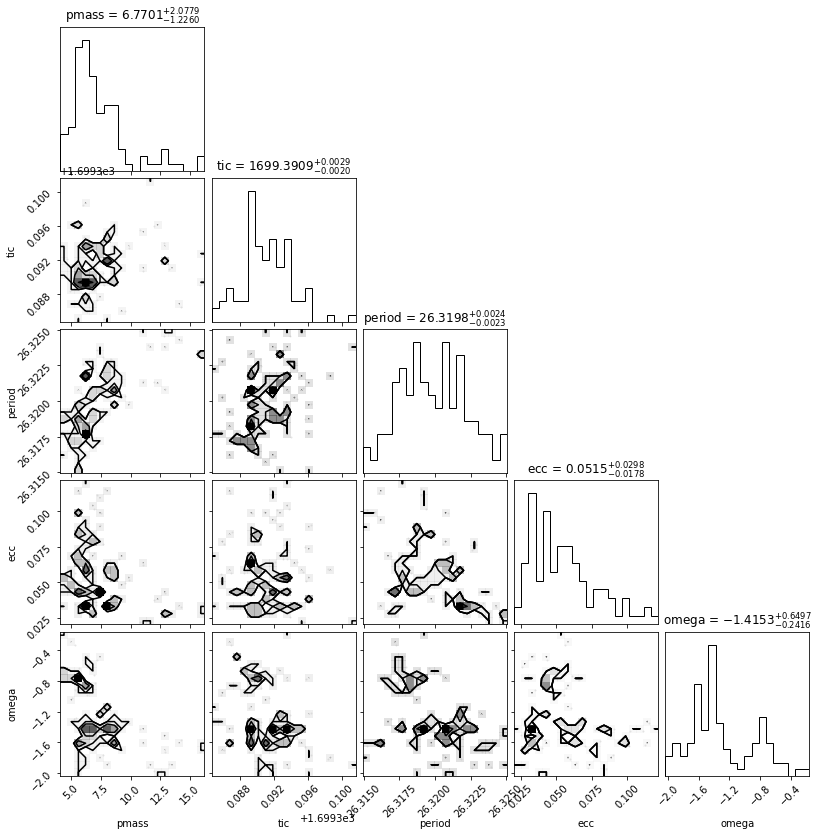

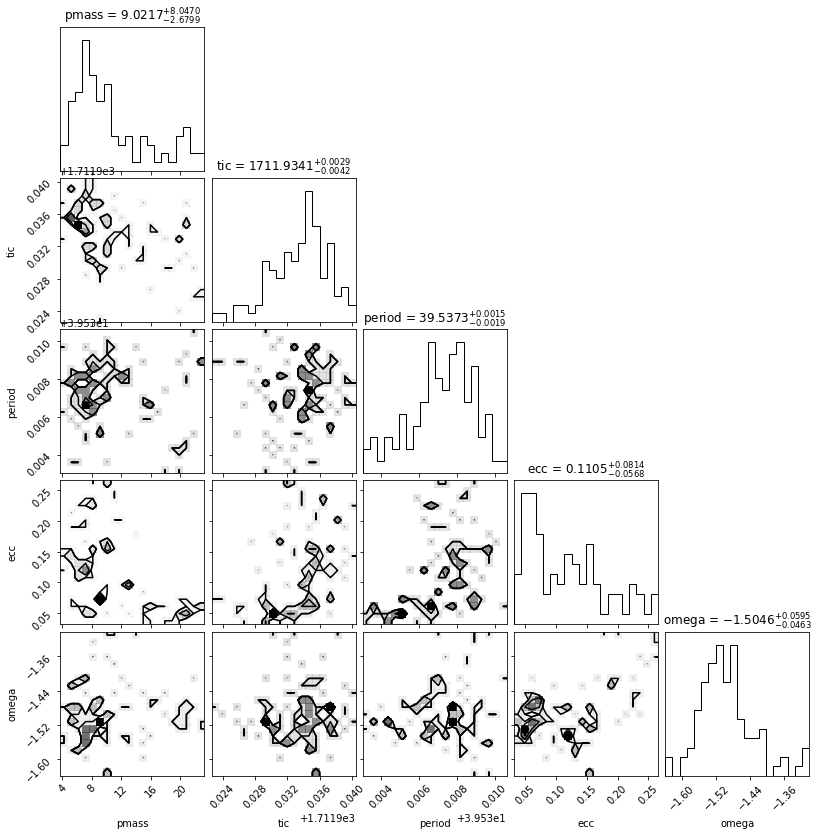

In [33]:
for j in range(jttv.nplanet):
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k][:,j] for k in keys])))
    fig = corner.corner(hyper, labels=keys, show_titles=True, title_fmt=".4f")
    plt.savefig(outdir+"corner%d.png"%(j+1), dpi=200, bbox_inches="tight");

In [29]:
jttv2 = jaxttv(t_start, t_end, dt / 5.)
jttv2.set_tcobs(tcobs, p_init, errorobs=errorobs)

# sympletic integrator is used.
# integration starts at:           1680.00
# first transit time in data:      1684.28
# last transit time in data:       2650.03
# integration ends at:             2655.00
# integration time step:           0.0200 (1/208 of innermost period)


In [30]:
k = 100

In [31]:
tc1, ediff1 = jttv2.get_ttvs(samples['elements'][k], jnp.hstack([1., samples['mass'][k]]))

(array([ 2.,  1., 21., 23.,  4., 11.,  6.,  2.,  6.,  6.]),
 array([-0.08730304, -0.05605577, -0.02480851,  0.00643875,  0.03768601,
         0.06893327,  0.10018053,  0.13142779,  0.16267505,  0.19392231,
         0.22516957]),
 <BarContainer object of 10 artists>)

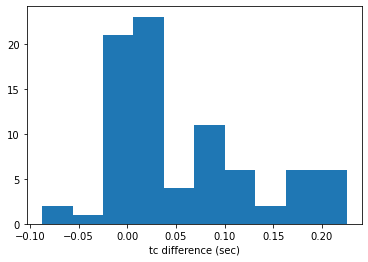

In [32]:
plt.xlabel("tc difference (sec)")
plt.hist(np.array(samples['tcmodel'][k] - tc1)*86400)